In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Path definitions

In [2]:
DATASETS_PATH = 'Datasets/'
MASTER_DATASET = 'MBTA_Bus_Commuter_Rail_Rapid_Transit_Reliability.csv'
MASTER_DATASET_PATH = os.path.join(DATASETS_PATH, MASTER_DATASET)

# Data Extraction

In [3]:
master_df = pd.read_csv(MASTER_DATASET_PATH)
master_df

,service_date,gtfs_route_id,gtfs_route_short_name,gtfs_route_long_name,gtfs_route_desc,route_category,mode_type,peak_offpeak_ind,metric_type,otp_numerator,otp_denominator,cancelled_numerator,ObjectId
0,2024/12/31 05:00:00+00,553,553,NaN,Express Bus,Other Bus,Bus,OFF_PEAK,Headway / Schedule Adherence,62.0,90.0,NaN,1
1,2024/12/31 05:00:00+00,554,554,NaN,Express Bus,Other Bus,Bus,OFF_PEAK,Headway / Schedule Adherence,23.0,25.0,NaN,2
2,2024/12/31 05:00:00+00,556,556,NaN,Express Bus,Other Bus,Bus,OFF_PEAK,Headway / Schedule Adherence,18.0,22.0,NaN,3
3,2024/12/31 05:00:00+00,558,558,NaN,Express Bus,Other Bus,Bus,OFF_PEAK,Headway / Schedule Adherence,18.0,20.0,NaN,4
4,2024/12/31 05:00:00+00,22,22,NaN,Key Bus Route (Frequent Service),Key Bus,Bus,OFF_PEAK,Headway / Schedule Adherence,935.0,1193.0,NaN,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
931869,2016/01/02 05:00:00+00,23,23,NaN,Key Bus Route (Frequent Service),Key Bus,Bus,OFF_PEAK,Headway / Schedule Adherence,1437.0,1881.0,0.0,931870
931870,2016/01/02 05:00:00+00,225,225,NaN,Local Bus,Other Bus,Bus,OFF_PEAK,Headway / Schedule Adherence,352.0,438.0,0.0,931871
931871,2016/01/02 05:00:00+00,222,222,NaN,Local Bus,Other Bus,Bus,OFF_PEAK,Headway / Schedule Adherence,224.0,269.0,0.0,931872
931872,2016/01/02 05:00:00+00,220,220,NaN,Local Bus,Other Bus,Bus,OFF_PEAK,Headway / Schedule Adherence,341.0,416.0,0.0,931873


In [4]:
bus_data = master_df[master_df['mode_type'] == 'Bus'].drop(columns=['mode_type'])

In [5]:
bus_data

,service_date,gtfs_route_id,gtfs_route_short_name,gtfs_route_long_name,gtfs_route_desc,route_category,peak_offpeak_ind,metric_type,otp_numerator,otp_denominator,cancelled_numerator,ObjectId
0,2024/12/31 05:00:00+00,553,553,NaN,Express Bus,Other Bus,OFF_PEAK,Headway / Schedule Adherence,62.0,90.0,NaN,1
1,2024/12/31 05:00:00+00,554,554,NaN,Express Bus,Other Bus,OFF_PEAK,Headway / Schedule Adherence,23.0,25.0,NaN,2
2,2024/12/31 05:00:00+00,556,556,NaN,Express Bus,Other Bus,OFF_PEAK,Headway / Schedule Adherence,18.0,22.0,NaN,3
3,2024/12/31 05:00:00+00,558,558,NaN,Express Bus,Other Bus,OFF_PEAK,Headway / Schedule Adherence,18.0,20.0,NaN,4
4,2024/12/31 05:00:00+00,22,22,NaN,Key Bus Route (Frequent Service),Key Bus,OFF_PEAK,Headway / Schedule Adherence,935.0,1193.0,NaN,5
...,...,...,...,...,...,...,...,...,...,...,...,...
931869,2016/01/02 05:00:00+00,23,23,NaN,Key Bus Route (Frequent Service),Key Bus,OFF_PEAK,Headway / Schedule Adherence,1437.0,1881.0,0.0,931870
931870,2016/01/02 05:00:00+00,225,225,NaN,Local Bus,Other Bus,OFF_PEAK,Headway / Schedule Adherence,352.0,438.0,0.0,931871
931871,2016/01/02 05:00:00+00,222,222,NaN,Local Bus,Other Bus,OFF_PEAK,Headway / Schedule Adherence,224.0,269.0,0.0,931872
931872,2016/01/02 05:00:00+00,220,220,NaN,Local Bus,Other Bus,OFF_PEAK,Headway / Schedule Adherence,341.0,416.0,0.0,931873


### Cleaning date column

In [6]:
bus_data['date'] = pd.to_datetime(bus_data['service_date'])
bus_data['date'] = bus_data['date'].dt.date
bus_data['date']

0         2024-12-31
1         2024-12-31
2         2024-12-31
3         2024-12-31
4         2024-12-31
             ...    
931869    2016-01-02
931870    2016-01-02
931871    2016-01-02
931872    2016-01-02
931873    2016-01-02
Name: date, Length: 807796, dtype: object

# Performances during Peak and off-Peak time

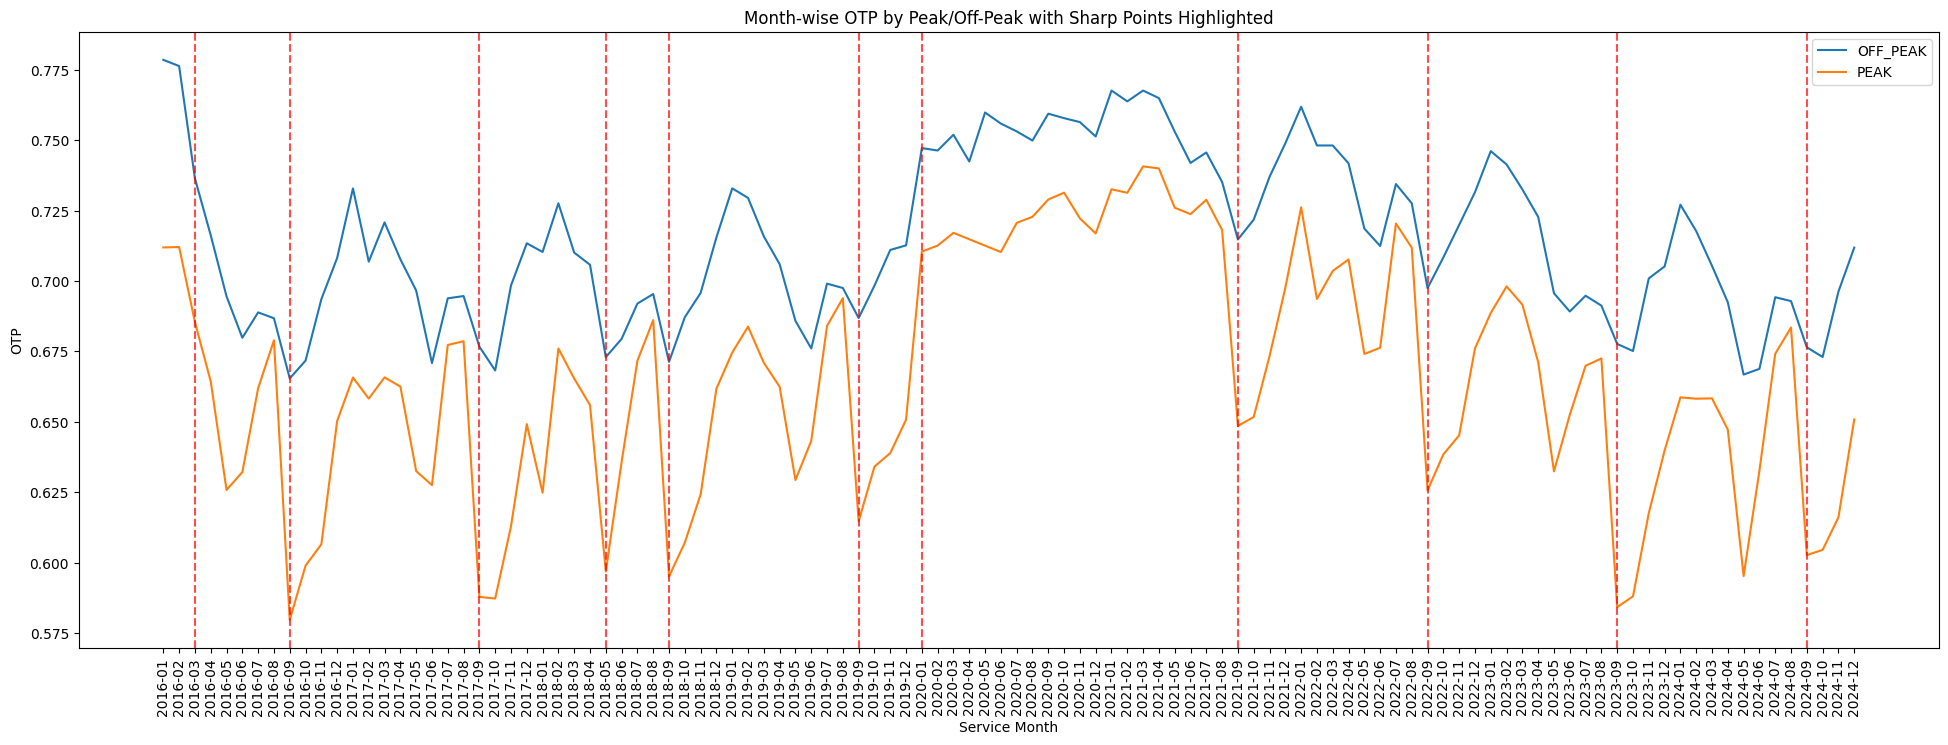

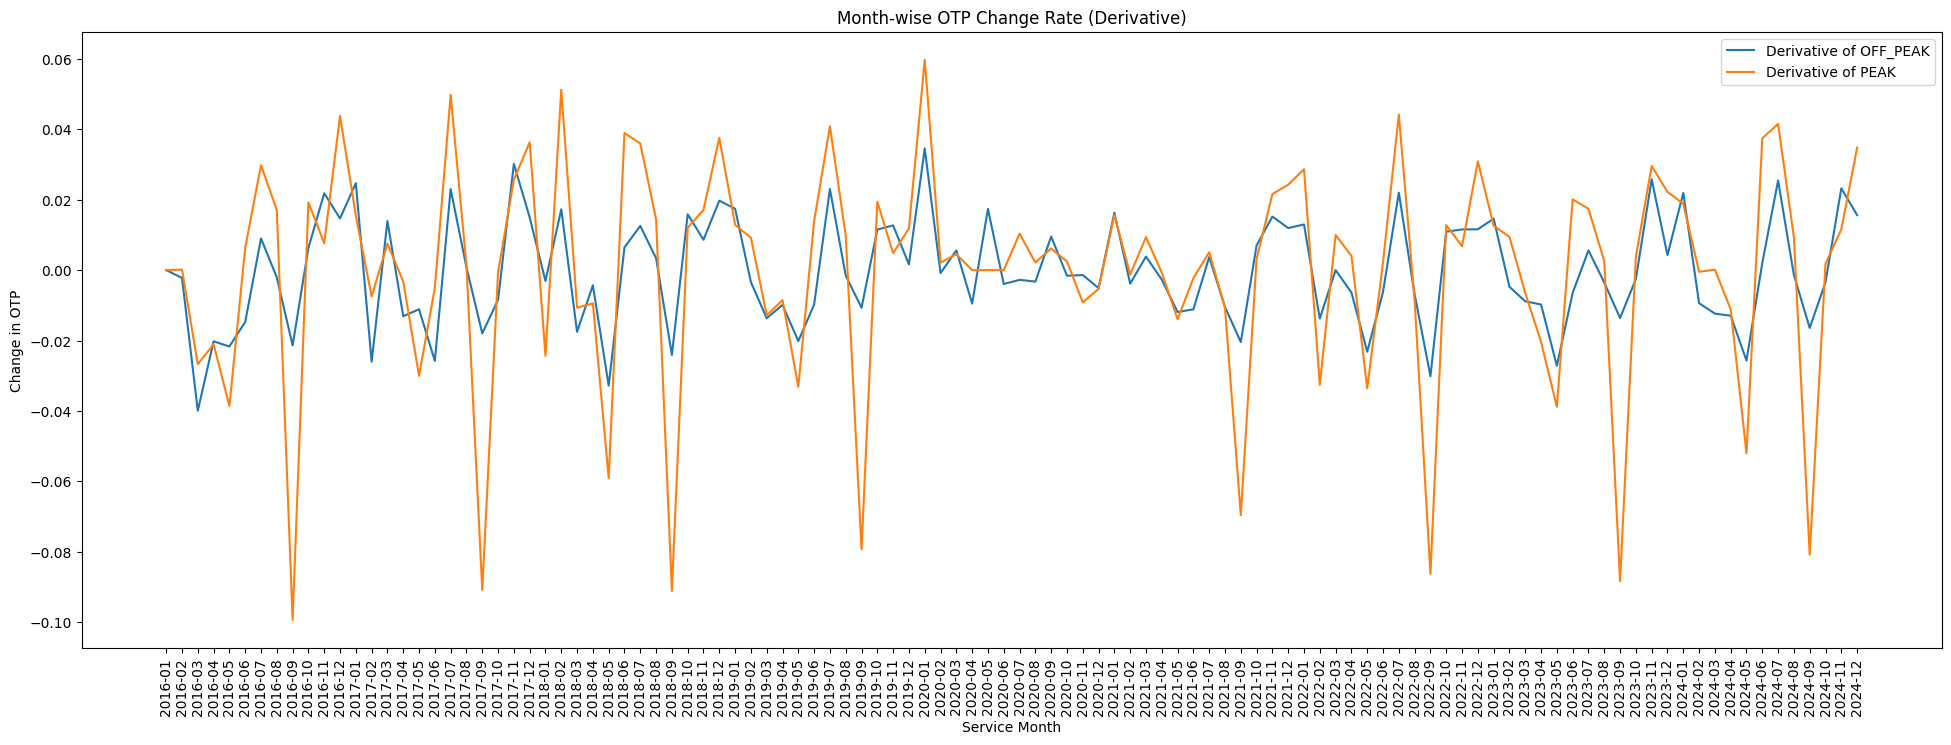

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

possible_peaks = bus_data['peak_offpeak_ind'].unique()
temp_sets = {}

for peak in possible_peaks:
    peak_data = bus_data[bus_data['peak_offpeak_ind'] == peak].copy()
    peak_data['date'] = pd.to_datetime(peak_data['date']).dt.to_period('M')
    temp_sets[peak] = peak_data

plt.figure(figsize=(24, 8))

# Dictionary to store sharp points
sharp_points = set()

for label, df_set in temp_sets.items():  # Renamed "set" to "df_set"
    df = df_set.groupby(['date']).agg({'otp_numerator': 'sum', 'otp_denominator': 'sum'}).copy()
    df['otp'] = df['otp_numerator'] / df['otp_denominator']
    df['dy_dx'] = df['otp'].diff()
    df['dy_dx'] = df['dy_dx'].fillna(0)

    # Identify sharp points (change > threshold)
    threshold = df['dy_dx'].std() * 2  # Adjust as needed
    sharp_dates = df[abs(df['dy_dx']) > threshold].index.astype(str)
    sharp_points.update(sharp_dates)  # Store for later use

    # Plot OTP trend
    sns.lineplot(x=df.index.astype(str), y='otp', data=df, label=label)

# Add vertical lines for sharp points
for point in sharp_points:
    plt.axvline(x=point, color='red', linestyle='--', alpha=0.7)

plt.title('Month-wise OTP by Peak/Off-Peak with Sharp Points Highlighted')
plt.xlabel('Service Month')
plt.ylabel('OTP')
plt.legend()
plt.xticks(rotation=90)
plt.show()

# Second Plot: Derivative of OTP
plt.figure(figsize=(24, 8))

for label, df_set in temp_sets.items():  # Renamed "set" to "df_set"
    df = df_set.groupby(['date']).agg({'otp_numerator': 'sum', 'otp_denominator': 'sum'}).copy()
    df['otp'] = df['otp_numerator'] / df['otp_denominator']
    df['dy_dx'] = df['otp'].diff()
    df['dy_dx'] = df['dy_dx'].fillna(0)

    sns.lineplot(x=df.index.astype(str), y='dy_dx', data=df, label="Derivative of " + label)

plt.title('Month-wise OTP Change Rate (Derivative)')
plt.xlabel('Service Month')
plt.ylabel('Change in OTP')
plt.legend()
plt.xticks(rotation=90)
plt.show()


# On time performance for each bus over the years

In [41]:
route_level_data = bus_data.copy()

# Ensure the route short name is set properly
route_level_data['gtfs_route_short_name'] = route_level_data['gtfs_route_short_name'].where(
    route_level_data['gtfs_route_short_name'].notna(), route_level_data['gtfs_route_id']
)

# Convert service_date to datetime and then to 6-month periods
route_level_data['date'] = pd.to_datetime(route_level_data['service_date']).dt.to_period('Y')
route_level_data = route_level_data.groupby(['gtfs_route_short_name', 'date']).agg({'otp_numerator': 'sum', 'otp_denominator': 'sum'}).reset_index()


/tmp/ipykernel_30320/2086546561.py:9: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  route_level_data['date'] = pd.to_datetime(route_level_data['service_date']).dt.to_period('Y')


In [42]:
important_routes = [ '22', '29', '15', '45', '44', '42', '17', '23', '31', '26', '111', '24', '33', '14']
color_palette = ["Maroon", "Grey", "Olive", "Teal", "Navy", "Black", "Red", "Orange", "Yellow", "Green", "Cyan", "Blue", "Purple", "Magenta"]

/tmp/ipykernel_30320/266187030.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_bus_data['otp'] = single_bus_data['otp_numerator'] / single_bus_data['otp_denominator']
/tmp/ipykernel_30320/266187030.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_bus_data['otp'] = single_bus_data['otp_numerator'] / single_bus_data['otp_denominator']
/tmp/ipykernel_30320/266187030.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

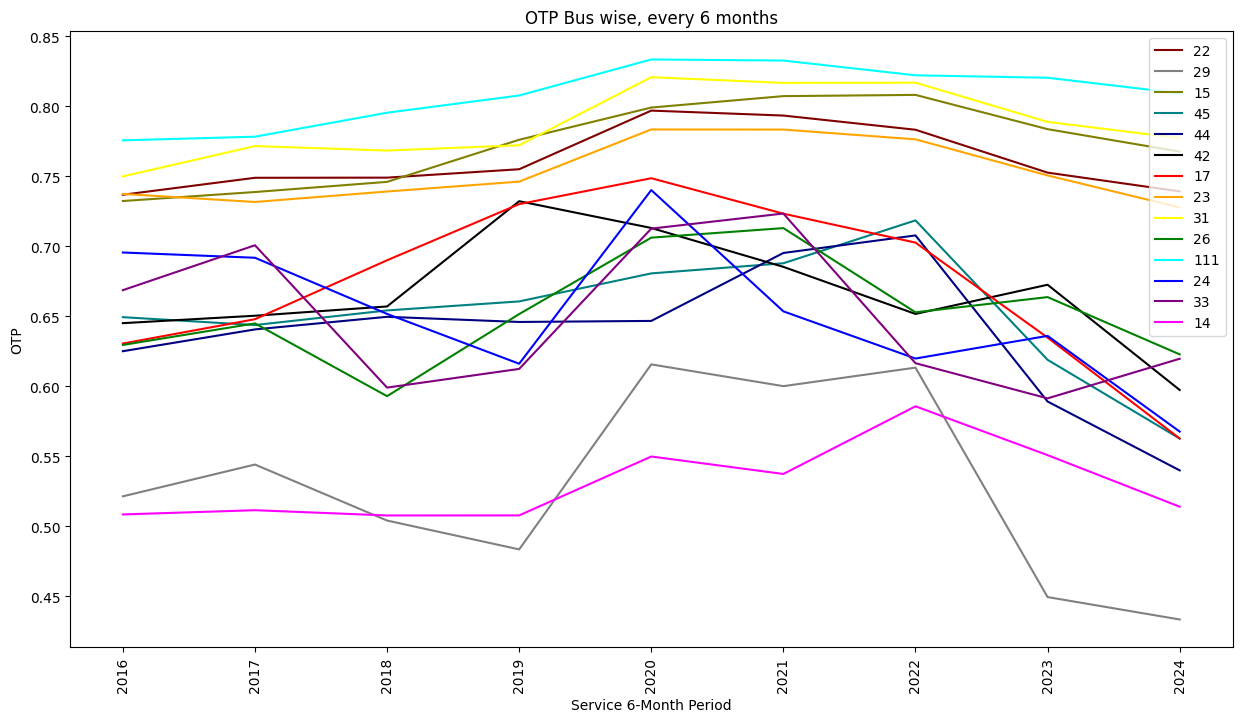

In [47]:
# Create the plot
plt.figure(figsize=(15, 8))
palette = sns.color_palette(color_palette, len(important_routes))

# Plot each important bus route
for idx, bus_name in enumerate(important_routes):
    single_bus_data = route_level_data[route_level_data['gtfs_route_short_name'] == bus_name]
    single_bus_data['otp'] = single_bus_data['otp_numerator'] / single_bus_data['otp_denominator']
    
    # Convert the period to string for x-axis
    sns.lineplot(x=single_bus_data['date'].astype(str), y='otp', data=single_bus_data, label=bus_name, color=palette[idx])

# Customize the plot
plt.title(f'OTP Bus wise, every 6 months')
plt.xlabel('Service 6-Month Period')
plt.ylabel('OTP')
plt.legend(loc='upper right')
plt.xticks(rotation=90)
plt.show()